# **Catégorisez automatiquement des questions**

## partie 1/8 : analyse exploratoire

### <br> Notebook d’exploration et de pré-traitement des questions, comprenant une analyse univariée et multivariée, un nettoyage des questions, un feature engineering de type bag of words avec réduction de dimension (du vocabulaire et des tags) 

<br>


## 1 Objectifs, imports


### 1.1 Contexte


In [2]:
# Nous avons téléchargé 50 000 questions posées sur stack overflow,
# ainsi que les tags associés.

# Objectifs de notebook :

# Comprendre nos données (forme, structure)
# premier nettoyage -> reduction dim
# Avoir une première représentation de nos données
# Rechercher des patterns
# se faire une idée de la difficulté de la tâche (prédiction de tags)
# (encore et surtout) : transformations en vue de reduction dim

# => traitement de strings avec nltk, regex, etc..
# tester spacy

# Dans le cadre de ce projet :
# Nous avons en input un fichier csv contenant 50 000 lignes.
# Les colonnes sont le titres, la questions (body), les tags, etc...
# Nous avons besoin en output de représentations spécifiques, pour nos différents modèles.

# Pour les modèles non-supervisé, il nous faut :
# - un bag of words pour la LDA (/algos similaires)
# - un TS-IDF pour la NMF
# Dans les deux cas (matrices sparse), cela implique un cleaning "aggressif", visant à conserver uniquement
# les mots qui ont du sens pour ce projet (= qui aident la prédiction de tag par les modèles).
# encore et tjs, la reduction dim !

# / supervisés ?


### 1.2 Importation des librairies, réglages


In [3]:
import os, sys, random
from zipfile import ZipFile
import numpy as np
import pandas as pd
from pandarallel import pandarallel

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
# import plotly.graph_objects as go
from wordcloud import WordCloud
from PIL import Image

# NLP
from bs4 import BeautifulSoup
import re, string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
# from collections import Counter
# if necessary
# !python -m spacy download en_core_web_sm
# !python -m spacy download en_core_web_md
import spacy

# Feature engineering
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

print('\nPython version ' + sys.version)
print('pandas version ' + pd.__version__)
print('sns version ' + sns.__version__)

plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)
sns.set(font_scale=1)

# Make sure we downloaded the models successfully
nlp = spacy.load("en_core_web_sm")
nlp = spacy.load("en_core_web_md")

# Modify if necessary
num_cores = os.cpu_count()
print(f"\nNumber of CPU cores: {num_cores}")
pandarallel.initialize(progress_bar=False, nb_workers=6)


[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ubuntu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ubuntu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!



Python version 3.11.4 (main, Jul  5 2023, 14:15:25) [GCC 11.2.0]
pandas version 2.1.4
sns version 0.12.2



Number of CPU cores: 8
INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


### 1.3 Fonctions


In [4]:
# Principalement des fonctions pour l'affichage des graphiques pdt l'EDA

def quick_look(df, miss=True):
    """
    Display a quick overview of a DataFrame, including shape, head, tail, unique values, and duplicates.

    Args:
        df (pandas.DataFrame): The input DataFrame to inspect.
        check_missing (bool, optional): Whether to check and display missing values (default is True).

    The function provides a summary of the DataFrame, including its shape, the first and last rows, the count of unique values per column, and the number of duplicates.
    If `check_missing` is set to True, it also displays missing value information.
    """
    print(f'shape : {df.shape}')

    display(df.head())
    display(df.tail())

    print('uniques :')
    display(df.nunique())

    print('Doublons ? ', df.duplicated(keep='first').sum(), '\n')

    if miss:
        display(get_missing_values(df))


def lerp(a, b, t):
    """
    Linear interpolation between two values 'a' and 'b' at a parameter 't'.
    A very useful little function, used here to position annotations in plots.
    Got it coding with Radu :)

    Given two values 'a' and 'b', and a parameter 't',
    this function calculates the linear interpolation between 'a' and 'b' at 't'.

    Parameters:
    a (float or int): The start value.
    b (float or int): The end value.
    t (float): The interpolation parameter (typically in the range [0, 1], but can be outside).

    Returns:
    float or int: The interpolated value at parameter 't'.
    """
    return a + (b - a) * t


def generate_random_pastel_colors(n):
    """
    Generates a list of n random pastel colors, represented as RGBA tuples.

    Parameters:
    n (int): The number of pastel colors to generate.

    Returns:
    list: A list of RGBA tuples representing random pastel colors.

    Example:
    >>> generate_random_pastel_colors(2)
    [(0.749, 0.827, 0.886, 1.0), (0.886, 0.749, 0.827, 1.0)]
    """
    colors = []
    for _ in range(n):
        # Generate random pastels
        red = round(random.randint(150, 250) / 255.0, 3)
        green = round(random.randint(150, 250) / 255.0, 3)
        blue = round(random.randint(150, 250) / 255.0, 3)

        # Create an RGB color tuple and add it to the list
        color = (red,green,blue, 1.0)
        colors.append(color)

    return colors

print(generate_random_pastel_colors(2))


def get_missing_values(df):
    """Generates a DataFrame containing the count and proportion of missing values for each feature.

    Args:
        df (pandas.DataFrame): The input DataFrame to analyze.

    Returns:
        pandas.DataFrame: A DataFrame with columns for the feature name, count of missing values,
        count of non-missing values, proportion of missing values, and data type for each feature.
    """
    # Count the missing values for each column
    missing = df.isna().sum()

    # Calculate the percentage of missing values
    percent_missing = df.isna().mean() * 100

    # Create a DataFrame to store the results
    missings_df = pd.DataFrame({
        'column_name': df.columns,
        'missing': missing,
        'present': df.shape[0] - missing,  # Count of non-missing values
        'percent_missing': percent_missing.round(2),  # Rounded to 2 decimal places
        'type': df.dtypes
    })

    # Sort the DataFrame by the count of missing values
    missings_df.sort_values('missing', inplace=True)

    return missings_df

# with pd.option_context('display.max_rows', 1000):
#   display(get_missing_values(df))


def hist_distrib(dataframe, feature, bins, decimal_places, density=True):
    """
    Visualize the empirical distribution of a numerical feature using a histogram.
    Calcul des principaux indicateurs de tendance centrale, dispersion et forme.

    Args:
        dataframe (pandas.DataFrame): The input DataFrame containing the feature.
        feature (str): The name of the numerical feature to visualize.
        bins (int): The number of bins for the histogram.
        decimal_places (int): The number of decimal places for rounding numeric values.
        density (bool, optional): Whether to display the histogram as a density plot (default is True).

    Returns:
        float: The skewness of the feature's distribution.

    The function generates a histogram of the feature, displays various statistics, and returns the skewness of the distribution.
    """
    # Calculate central tendencies and dispersion
    mode_value = round(dataframe[feature].mode()[0], decimal_places)
    mode_non_zero = "N/A"
    if (dataframe[feature] != 0).any():
        mode_non_zero = round(dataframe.loc[dataframe[feature] != 0, feature].mode()[0], decimal_places)
    median_value = round(dataframe[feature].median(), decimal_places)
    mean_value = round(dataframe[feature].mean(), decimal_places)

    # Calculate dispersion
    var_emp = round(dataframe[feature].var(ddof=0), decimal_places)
    coeff_var = round(dataframe[feature].std(ddof=0), decimal_places)

    # Calculate shape indicators
    skewness_value = round(dataframe[feature].skew(), 2)
    kurtosis_value = round(dataframe[feature].kurtosis(), 2)

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 5))
    dataframe[feature].hist(density=density, bins=bins, ax=ax)

    # Adjust placement for annotations
    yt = plt.yticks()
    y_position = lerp(yt[0][0], yt[0][-1], 0.8)
    y_increment = y_position / 20
    xt = plt.xticks()
    x_position = lerp(xt[0][0], xt[0][-1], 0.7)

    # Add annotations with horizontal and vertical alignment
    annotation_fs = 13
    color = 'g'
    ax.annotate(f'Mode: {mode_value}', xy=(x_position, y_position), fontsize=annotation_fs,
                xytext=(x_position, y_position), color=color, ha='left', va='bottom')
    ax.annotate(f'Mode +: {mode_non_zero}', xy=(x_position, y_position - y_increment), fontsize=annotation_fs,
                xytext=(x_position, y_position - y_increment), color=color, ha='left', va='bottom')
    ax.annotate(f'Median: {median_value}', xy=(x_position, y_position - 2 * y_increment), fontsize=annotation_fs,
                xytext=(x_position, y_position - 2 * y_increment), color=color, ha='left', va='bottom')
    ax.annotate(f'Mean: {mean_value}', xy=(x_position, y_position - 3 * y_increment), fontsize=annotation_fs,
                xytext=(x_position, y_position - 3 * y_increment), color=color, ha='left', va='bottom')
    ax.annotate(f'Var Emp: {var_emp}', xy=(x_position, y_position - 5 * y_increment), fontsize=annotation_fs,
                xytext=(x_position, y_position - 5 * y_increment), color=color, ha='left', va='bottom')
    ax.annotate(f'Coeff Var: {coeff_var}', xy=(x_position, y_position - 6 * y_increment), fontsize=annotation_fs,
                xytext=(x_position, y_position - 6 * y_increment), color=color, ha='left', va='bottom')
    ax.annotate(f'Skewness: {skewness_value}', xy=(x_position, y_position - 8 * y_increment), fontsize=annotation_fs,
                xytext=(x_position, y_position - 8 * y_increment), color=color, ha='left', va='bottom')
    ax.annotate(f'Kurtosis: {kurtosis_value}', xy=(x_position, y_position - 9 * y_increment), fontsize=annotation_fs,
                xytext=(x_position, y_position - 9 * y_increment), color=color, ha='left', va='bottom')

    # Label the x-axis and y-axis
    ax.set_xlabel(feature, fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)

    # Show the plot
    plt.title(f'Distribution of {feature}', pad=20, fontsize=18)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

    return skewness_value


def boxplot_distrib(dataframe, feature):
    """
    Affiche un boxplot, pour visualiser les tendances centrales et la dispersion d'une variable.

    Args:
        dataframe (pandas.DataFrame): The input DataFrame containing the feature.
        feature (str): The name of the numerical feature to visualize.

    The function generates a box plot of the feature to display central tendencies (median and mean) and dispersion.
    """
    fig, ax = plt.subplots(figsize=(10, 4))

    medianprops = {'color':"blue"}
    meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}

    dataframe.boxplot(feature, vert=False, showfliers=False, medianprops=medianprops, patch_artist=True, showmeans=True, meanprops=meanprops)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()


def courbe_lorenz(dataframe, feature):
    """
    Affiche une courbe de Lorenz, pour visualiser la concentration d'une variable
    Calcule l'indice de Gini
    Visualize a Lorenz curve to assess the concentration of a variable and calculate the Gini coefficient.

    Args:
        dataframe (pandas.DataFrame): The input DataFrame containing the feature.
        feature (str): The name of the numerical feature to visualize.

    The function generates a Lorenz curve to assess the concentration of the feature and calculates the Gini coefficient.
    """
    fig, ax = plt.subplots(figsize=(12, 5))
    values = dataframe.loc[dataframe[feature].notna(), feature].values
    # print(values)
    n = len(values)
    lorenz = np.cumsum(np.sort(values)) / values.sum()
    lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0

    xaxis = np.linspace(0-1/n,1+1/n,n+1)
    #Il y a un segment de taille n pour chaque individu, plus 1 segment supplémentaire d'ordonnée 0.
    # #Le premier segment commence à 0-1/n, et le dernier termine à 1+1/n.
    plt.plot(xaxis,lorenz,drawstyle='steps-post')
    plt.plot(np.arange(2),[x for x in np.arange(2)])
    # calcul de l'indice de Gini
    AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n # Surface sous la courbe de Lorenz. Le premier segment (lorenz[0]) est à moitié en dessous de 0, on le coupe donc en 2, on fait de même pour le dernier segment lorenz[-1] qui est à moitié au dessus de 1.
    S = 0.5 - AUC # surface entre la première bissectrice et le courbe de Lorenz
    gini = 2*S
    plt.annotate('gini =  ' + str(round(gini, 2)), xy = (0.04, 0.88), fontsize = 13, xytext = (0.04, 0.88), color = 'g')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()


def graphs_analyse_uni(dataframe, feature, bins=50, r=5, density=True):
    """
    Affiche histogramme + boxplot + courbe de Lorenz

    Args:
        dataframe (pandas.DataFrame): The input DataFrame containing the feature.
        feature (str): The name of the numerical feature to analyze.
        bins (int, optional): The number of bins for the histogram (default is 50).
        decimal_places (int, optional): The number of decimal places for rounding numeric values (default is 5).
        density (bool, optional): Whether to display the histogram as a density plot (default is True).

    The function generates and displays an analysis of the given numerical feature, including an histogram, a box plot, and a Lorenz curve.
    """
    hist_distrib(dataframe, feature, bins, r)
    boxplot_distrib(dataframe, feature)
    courbe_lorenz(dataframe, feature)


def shape_head(df, nb_rows=5):
    """
    Affiche les dimensions et les premières lignes dùun dataframe
    Display the dimensions and the first rows of a DataFrame.

    Args:
        df (pandas.DataFrame): The input DataFrame to display.
        nb_rows (int, optional): The number of rows to display (default is 5, max is 60).

    The function prints the dimensions of the DataFrame and displays the first few rows.
    """
    print(df.shape)
    display(df.head(nb_rows))


def doughnut(df, feature, title, width=10, height=10):
    """
    Affiche la répartition d'une feature sous forme de diagramme circulaire
    Display the distribution of a feature as a doughnut chart.
    Les couleurs sont aléatoires.

    Args:
        df (pandas.DataFrame): The input DataFrame containing the feature.
        feature (str): The name of the feature to visualize.
        title (str): The title for the doughnut chart.
        width (int, optional): The width of the chart (default is 10).
        height (int, optional): The height of the chart (default is 10).

    The function creates a doughnut chart to visualize the distribution of the specified feature.
    If you don't like the colors, try running it again :)
    """
    colors = generate_random_pastel_colors(20)

    grouped_df = df.groupby(feature).size().to_frame("count_per_type").reset_index()
    pie = grouped_df.set_index(feature).copy()

    fig, ax = plt.subplots(figsize=(width, height))

    patches, texts, autotexts = plt.pie(x=pie['count_per_type'], autopct='%1.1f%%',
        startangle=-30, labels=pie.index, textprops={'fontsize':11, 'color':'#000'},
        labeldistance=1.25, pctdistance=0.85, colors=colors)

    plt.title(
    label=title,
    fontdict={"fontsize":17},
    pad=20
    )

    for text in texts:
        # text.set_fontweight('bold')
        text.set_horizontalalignment('center')

    # Customize percent labels
    for autotext in autotexts:
        autotext.set_horizontalalignment('center')
        autotext.set_fontstyle('italic')
        autotext.set_fontsize('10')

    #draw circle
    centre_circle = plt.Circle((0,0),0.7,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    plt.show()


def get_non_null_values(df):
    """
    Génère un dataframe contenant le nombre et la proportion de non-null (non-zero) valeurs pour chaque feature
    Generate a DataFrame containing the count and proportion of non-null (non-zero) values for each feature.

    Args:
        df (pandas.DataFrame): The input DataFrame to analyze.

    The function calculates and returns a DataFrame with the count and percentage of non-null (non-zero) values for each feature.
    """
    non_null_counts = df.ne(0).sum()
    percent_non_null = (non_null_counts / df.shape[0]) * 100
    non_null_values_df = pd.DataFrame({'column_name': df.columns,
                                       'non_null_count': non_null_counts,
                                       'percent_non_null': percent_non_null.round(2),
                                       'type': df.dtypes})
    non_null_values_df.sort_values('non_null_count', inplace=True)
    return non_null_values_df


def get_colors(n=7):
    """
    Generate a list of random colors from multiple colormaps.

    Args:
        n (int, optional): The number of colors to sample from each colormap (default is 7).

    Returns:
        list: A list of random colors sampled from different colormaps.
    """
    num_colors_per_colormap = n
    colormaps = [plt.cm.Pastel2, plt.cm.Set1, plt.cm.Paired]
    all_colors = []

    for colormap in colormaps:
        colors = colormap(np.linspace(0, 1, num_colors_per_colormap))
        all_colors.extend(colors)

    np.random.shuffle(all_colors)

    return all_colors


[(0.624, 0.882, 0.867, 1.0), (0.608, 0.588, 0.616, 1.0)]


## 2 EDA et preprocessing des questions (mostly NLTK)


### 2.1 Importation des données brutes


In [5]:
# Données compressées sinon on dépasse la limite /objet de Github (50Mb)

# path to the zip file
zip_file_path = './../data/raw_data/QueryResults.zip'

# directory where you want to extract the contents
extract_to_dir = './../data/raw_data'

# Open the zip file
with ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents into the specified directory
    zip_ref.extractall(extract_to_dir)

# L'encodage est bien UTF-8 (vérifié en ouvrant le .csv ds vscode)
raw_data = pd.read_csv('./../data/raw_data/QueryResults.csv', sep=',')

quick_look(raw_data)


shape : (50000, 9)


,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount,CreationDate
0,ImportError: cannot import name 'url_decode' f...,<p>I am building a webapp using Flask. I impor...,<python><flask><importerror><flask-login><werk...,77215107,13,14443,NaN,5,2023-10-02 11:07:45
1,Compilation error after upgrading to JDK 21 - ...,"<p>After upgrading to JDK 21, I have the follo...",<spring-boot><compiler-errors><upgrade><lombok...,77171270,55,36788,NaN,3,2023-09-25 09:05:11
2,Differences between Langchain & LlamaIndex,<p>I'm currently working on developing a chatb...,<chatbot><openai-api><langchain><large-languag...,76990736,28,10433,NaN,2,2023-08-28 07:22:32
3,session not created: This version of ChromeDri...,<p>I am running a Docker image from a Docker c...,<python><amazon-web-services><docker><google-c...,76909437,14,14969,NaN,8,2023-08-15 22:21:03
4,Spring security method cannot decide pattern i...,<p>When I try to run an application it fails t...,<java><spring-boot><eclipse><spring-security><...,76809698,27,18943,NaN,8,2023-08-01 08:16:21


,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount,CreationDate
49995,How can I send a file document to the printer ...,<p>Here's the basic premise:</p>\n\n<p>My user...,<c#><winforms><pdf><.net-4.0><printing>,6103705,91,215784,0.0,12,2011-05-23 22:22:56
49996,CA1014 Mark 'some.dll' with CLSCompliant(true)...,"<p>When I run StyleCop, I got this error messa...",<visual-studio><visual-studio-2010><dll><style...,6103133,17,11024,0.0,2,2011-05-23 21:15:51
49997,How to change a text file's name in C++?,<p>I would like to change a <code>txt</code> f...,<c++><algorithm><file><directory><file-rename>,6103036,16,37118,0.0,3,2011-05-23 21:05:59
49998,php implode (101) with quotes,<p>Imploding a simple array </p>\n\n<p>would ...,<php><arrays><string><csv><implode>,6102398,156,141141,0.0,16,2011-05-23 20:06:35
49999,What characters are allowed in a iOS file name?,<p>I'm looking for a way to make sure a string...,<ios><file><filenames><character-encoding><nsf...,6102333,29,26085,0.0,10,2011-05-23 20:00:57


uniques :


Title            49999
Body             50000
Tags             48252
Id               50000
Score              761
ViewCount        36831
FavoriteCount        2
AnswerCount         64
CreationDate     49994
dtype: int64

Doublons ?  0 



,column_name,missing,present,percent_missing,type
Title,Title,0,50000,0.00,object
Body,Body,0,50000,0.00,object
Tags,Tags,0,50000,0.00,object
Id,Id,0,50000,0.00,int64
Score,Score,0,50000,0.00,int64
ViewCount,ViewCount,0,50000,0.00,int64
AnswerCount,AnswerCount,0,50000,0.00,int64
CreationDate,CreationDate,0,50000,0.00,object
FavoriteCount,FavoriteCount,1827,48173,3.65,float64


In [6]:
# Pas de valeurs manquantes, à part FavoriteCount (pas important)

# Seulement 2 titres identiques / 50 000 lignes
# id est bien une clé primaire
# body aussi, pas de questions en doublon (identiques)

# On a environ 48 000 ensembles de tags différents, vérifier + tard combien de tags uniques

# Les types semblent corrects,
# à part les dates bien sûr

raw_data['CreationDate'] = pd.to_datetime(raw_data['CreationDate'])
# Après je pense qu'on n'utilisera jamais ces dates... Juste au cas où.
# Correction, elle seront utilisées (mais pas ds ce ntbook) pour mesurer la dégradation dans le tps
# (drift, etc...) de nos modèles.

raw_data.describe()

# Avec nos critères (cf requete sql, fin ntbk 2), il a fallu retourner jusqu'à mai 2011
# pour avoir 50 000 questions. On retrouve ici le favoriteCount très bas, proche de 0.
# On a une moyenne pour le score (environ 50), le nv de vues (66 000) et de réponses (>5)
# dans notre corpus.


,Id,Score,ViewCount,FavoriteCount,AnswerCount,CreationDate
count,5.000000e+04,50000.000000,5.000000e+04,48173.000000,50000.000000,50000
mean,2.878203e+07,49.973980,6.612881e+04,0.000083,5.384480,2015-02-23 09:48:58.933900032
min,6.102333e+06,11.000000,1.000200e+04,0.000000,2.000000,2011-05-23 20:00:57
25%,1.413152e+07,15.000000,1.842050e+04,0.000000,3.000000,2013-01-03 00:42:30.500000
50%,2.551682e+07,24.000000,3.210600e+04,0.000000,4.000000,2014-08-26 23:41:22
75%,4.133835e+07,45.000000,6.446725e+04,0.000000,6.000000,2016-12-27 02:23:45
max,7.721511e+07,27153.000000,1.063924e+07,1.000000,87.000000,2023-10-02 11:07:45
std,1.687404e+07,168.429881,1.424566e+05,0.009112,4.622519,NaN


In [7]:
raw_questions_tags = raw_data[['CreationDate', 'Title', 'Body', 'Tags']].copy()

# Rename columns
# Ici c'est juste pour enlever les majuscules
raw_questions_tags = raw_questions_tags.rename(columns={'Title': 'title',
                                                        'Body': 'body',
                                                        'Tags': 'Tags'.lower()}) # Pourquoi pas


### 2.2 Suppression des tags html


In [8]:
# Je ne vois pas de balises dans les titres
# mais j'avoue je n'ai pas lu les 50 000 titres, donc au cas où :

raw_questions_tags['title'] = raw_questions_tags['title'].parallel_apply(
    lambda x: BeautifulSoup(x, 'html.parser').get_text())

# Le warning n'a pas d'importance ici : du texte qui ne contient pas de tags html
# n'est pas modifié par BeautifulSoup.get_text()

# J'hésitais à concaténer title + body ici, mais on testera aussi les modeles seulement sur les titres
# pour avoir une baseline. On va donc conserver les 2 features, et les traiter en parallèle.


/tmp/ipykernel_18570/2496321965.py:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  lambda x: BeautifulSoup(x, 'html.parser').get_text())
/tmp/ipykernel_18570/2496321965.py:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  lambda x: BeautifulSoup(x, 'html.parser').get_text())
/tmp/ipykernel_18570/2496321965.py:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  lambda x: BeautifulSoup(x, 'html.parser').get_text())
/tmp/ipykernel_18570/2496321965.py:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  lambda x: BeautifulSoup(x, 'html.parser').get_text

In [9]:
raw_questions_tags['body'] = raw_questions_tags['body'].parallel_apply(
    lambda x: BeautifulSoup(x, 'html.parser').get_text())

quick_look(raw_questions_tags)

# environ 25s sans pandarallel -> 5-6s sur 6 cores
# pandarallel adopté !


shape : (50000, 4)


,CreationDate,title,body,tags
0,2023-10-02 11:07:45,ImportError: cannot import name 'url_decode' f...,I am building a webapp using Flask. I imported...,<python><flask><importerror><flask-login><werk...
1,2023-09-25 09:05:11,Compilation error after upgrading to JDK 21 - ...,"After upgrading to JDK 21, I have the followin...",<spring-boot><compiler-errors><upgrade><lombok...
2,2023-08-28 07:22:32,Differences between Langchain & LlamaIndex,I'm currently working on developing a chatbot ...,<chatbot><openai-api><langchain><large-languag...
3,2023-08-15 22:21:03,session not created: This version of ChromeDri...,I am running a Docker image from a Docker cont...,<python><amazon-web-services><docker><google-c...
4,2023-08-01 08:16:21,Spring security method cannot decide pattern i...,When I try to run an application it fails to s...,<java><spring-boot><eclipse><spring-security><...


,CreationDate,title,body,tags
49995,2011-05-23 22:22:56,How can I send a file document to the printer ...,Here's the basic premise:\nMy user clicks some...,<c#><winforms><pdf><.net-4.0><printing>
49996,2011-05-23 21:15:51,CA1014 Mark 'some.dll' with CLSCompliant(true)...,"When I run StyleCop, I got this error message ...",<visual-studio><visual-studio-2010><dll><style...
49997,2011-05-23 21:05:59,How to change a text file's name in C++?,"I would like to change a txt file's name, but ...",<c++><algorithm><file><directory><file-rename>
49998,2011-05-23 20:06:35,php implode (101) with quotes,Imploding a simple array \nwould look like th...,<php><arrays><string><csv><implode>
49999,2011-05-23 20:00:57,What characters are allowed in a iOS file name?,I'm looking for a way to make sure a string ca...,<ios><file><filenames><character-encoding><nsf...


uniques :


CreationDate    49994
title           49999
body            50000
tags            48252
dtype: int64

Doublons ?  0 



,column_name,missing,present,percent_missing,type
CreationDate,CreationDate,0,50000,0.0,datetime64[ns]
title,title,0,50000,0.0,object
body,body,0,50000,0.0,object
tags,tags,0,50000,0.0,object


### 2.3 Tokenisation, majuscules, ponctuation


In [10]:
# Après qq tests, le + efficace ici semble d'appliquer d'abord la fonction word_tokenize(),
# qui gère mieux beaucoup de spécificités de l'anglais (ex: contractions),
# puis le RegexpTokenizer pour 'découper' ensuite les adresses mails, URLS, etc...
# Il y aurait d'autres stratégies possibles, par exemples utiliser d'abord le module contractions.

def preprocess_1_tokenize(text, remove_punct=True):
    """
    Clean input text (lower, strip spaces), Tokenize, Remove punctuation (optional).

    Parameters:
    - text (str): Input text to tokenize.
    - remove_punct (bool): filter punctuation marks.

    Returns:
    - list: List of tokens, each token is a string.
    """
    # Nettoyage des majuscules et des espaces
    text = text.lower().strip()
    try:
        tokens = nltk.word_tokenize(text)
        tokenizer = nltk.RegexpTokenizer(r'\w+')
        tokens = tokenizer.tokenize(" ".join(tokens))  # Apply RegexpTokenizer to the entire list

        if remove_punct:
            # Remove punctuation (make sure, RegexpTokenizer should have done it already)
            tokens = [token for token in tokens if token not in string.punctuation]

    except Exception as e:
        print(f"Error in tokenization: {e}")
        return []

    return tokens

# Apply to 'title' column
raw_questions_tags['title_tokens'] = raw_questions_tags['title'].parallel_apply(
    lambda x: preprocess_1_tokenize(x))

# Count total number of tokens
raw_questions_tags['nb_tokens_title'] = raw_questions_tags['title_tokens'].apply(len)


In [11]:
# Idem for 'body' column
raw_questions_tags['body_tokens'] = raw_questions_tags['body'].parallel_apply(
    lambda x: preprocess_1_tokenize(x))

# Count total number of tokens
raw_questions_tags['nb_tokens_body'] = raw_questions_tags['body_tokens'].apply(len)



In [12]:
display(raw_questions_tags.describe())

# La question la + courte est composée de 7 tokens.
# La + longue, de presque 5000, soit... environ 15 pages ?!

display(raw_questions_tags.loc[(raw_questions_tags['nb_tokens_body'] == 7)
                               | (raw_questions_tags['nb_tokens_body'] == 4845), : ])

print(raw_questions_tags.loc[raw_questions_tags['nb_tokens_body'] == 4845, ['body']].values[0])
# Ca a l'air compliqué en effet ! A not so simple app


,CreationDate,nb_tokens_title,nb_tokens_body
count,50000,50000.000000,50000.000000
mean,2015-02-23 09:48:58.933900032,9.363800,199.352280
min,2011-05-23 20:00:57,1.000000,7.000000
25%,2013-01-03 00:42:30.500000,7.000000,80.000000
50%,2014-08-26 23:41:22,9.000000,134.000000
75%,2016-12-27 02:23:45,11.000000,229.000000
max,2023-10-02 11:07:45,33.000000,4845.000000
std,NaN,3.678146,243.059224


,CreationDate,title,body,tags,title_tokens,nb_tokens_title,body_tokens,nb_tokens_body
10350,2017-06-07 04:58:30,Using iOS8 and later devices with Xcode,Using iOS8 and later devices with Xcode?\n\n,<ios><xcode><ios10><ios11><ios12>,"[using, ios8, and, later, devices, with, xcode]",7,"[using, ios8, and, later, devices, with, xcode]",7
28506,2014-02-12 21:05:03,How to disable Spring logging DEBUG messages?,I'm working on a simple desktop app (not webap...,<java><spring><log4j><slf4j><apache-commons-lo...,"[how, to, disable, spring, logging, debug, mes...",7,"[i, m, working, on, a, simple, desktop, app, n...",4845
46140,2011-11-22 03:26:22,How do you sort and efficiently find elements ...,Is there built-in functionality for this?\n,<search><sorting><find><octave><cell-array>,"[how, do, you, sort, and, efficiently, find, e...",16,"[is, there, built, in, functionality, for, this]",7


['I\'m working on a simple desktop app (not webapp).\nHere is my log4j.properties:\nlog4j.rootCategory=INFO, stdout\n\nlog4j.appender.stdout=org.apache.log4j.ConsoleAppender\nlog4j.appender.stdout.layout=org.apache.log4j.PatternLayout\nlog4j.appender.stdout.layout.ConversionPattern=%d{ABSOLUTE} %5p %t %c{2}:%L $$$$ %m%n\n\nlog4j.logger.org.springframework=ERROR,stdout\n\nAs you can see, in order to eliminate Spring logging messages from the console, I tried this solution:\nDisabling Spring log, to have readable logs\nWhen I call log4j logger from my code, the logging messages are according to the pattern specified above (which is good).\nHowever, the bad part is - I still get to the console DEBUG level messages from spring... they look like here:\nUnable to disable logging messages\nAnd they have a different pattern. As if they ignore my settings.\nI also tried to apply the suggestions I\'ve found here:\nhttps://spring.io/blog/2009/12/04/logging-dependencies-in-spring\nIn my pom file:\

### 2.4 Concaténation title + body


In [13]:
# reunion des listes de tokens
raw_questions_tags['body_tokens'] = raw_questions_tags['title_tokens'] + raw_questions_tags['body_tokens']

raw_questions_tags['nb_tokens_body'] = raw_questions_tags['body_tokens'].apply(len)

display(raw_questions_tags.describe())
# On passe de 199 à 208 tokens en moyenne
# le nb min passe de 7 a 13


,CreationDate,nb_tokens_title,nb_tokens_body
count,50000,50000.000000,50000.000000
mean,2015-02-23 09:48:58.933900032,9.363800,208.716080
min,2011-05-23 20:00:57,1.000000,13.000000
25%,2013-01-03 00:42:30.500000,7.000000,89.000000
50%,2014-08-26 23:41:22,9.000000,143.000000
75%,2016-12-27 02:23:45,11.000000,239.000000
max,2023-10-02 11:07:45,33.000000,4852.000000
std,NaN,3.678146,243.426177


### 2.5 Fréquence des tokens


In [14]:
# Extract tokens
all_tokens = [token for tokens_list in raw_questions_tags['body_tokens'] for token in tokens_list]

print(f'Nombre de mots (en tout) : {len(all_tokens)}')
print(f'Nombre de mots (différents) : {len(set(all_tokens))}', '\n')
# + de 10 millions de "mots" (tokens),
# dont environ 270 000 différents !

# Calculate token frequencies using a loop
# J'ai découvert plus tard la fonction FreqDist() de nltk, qui fait la mm chose
token_frequencies_dict = {}
for token in all_tokens:
    token_frequencies_dict[token] = token_frequencies_dict.get(token, 0) + 1

# Display the first 50 items in the token frequencies dictionary (not sorted yet)
for token, frequency in list(token_frequencies_dict.items())[:50]:
    print(f"{token}: {frequency}")


Nombre de mots (en tout) : 10435804
Nombre de mots (différents) : 270412 

importerror: 400
can: 38752
not: 55151
import: 18979
name: 25854
url_decode: 3
from: 42808
werkzeug: 49
urls: 855
i: 268217
am: 27258
building: 1733
a: 154185
webapp: 486
using: 38379
flask: 1009
imported: 554
the: 309653
login: 3673
library: 6892
to: 229324
handle: 2123
user: 17296
but: 48412
it: 80299
shows: 1959
an: 31842
below: 6102
is: 123787
my: 54530
folder: 3020
structure: 1376
flask_blog1: 8
flaskblog: 10
static: 6439
templates: 566
__init__: 1423
py: 8086
forms: 1001
models: 2780
routes: 1022
instance: 3660
site: 4936
db: 3965
venv: 441
requirements: 590
txt: 2086
run: 16310
app: 25591
if: 40155


In [15]:
# Sort the dictionary items by values in descending order
sorted_token_frequencies = dict(sorted(token_frequencies_dict.items(), key=lambda item: item[1], reverse=True))

# Display the first 50 items in the token frequencies dictionary
for token, frequency in list(sorted_token_frequencies.items())[:50]:
    print(f"{token}: {frequency}")

# La plupart de ces mots appartiennent probablement à la liste des stopwords ?
# Note du futur : c plutôt l'inverse en fait, la liste des stopwords étant très courte (179 mots).

# tokens interessants : java, error, android, file, string, ...


the: 309653
i: 268217
to: 229324
a: 154185
in: 126918
is: 123787
and: 114639
0: 91350
this: 91189
of: 81721
it: 80299
1: 77595
for: 68406
that: 62213
with: 58205
not: 55151
my: 54530
at: 49885
on: 49457
but: 48412
2: 47996
have: 47298
java: 45597
from: 42808
if: 40155
how: 39647
can: 38752
using: 38379
as: 37984
t: 36721
n: 36359
error: 35901
android: 35687
be: 35530
do: 35150
org: 34579
file: 31942
an: 31842
class: 31621
3: 31248
s: 31089
get: 30312
new: 30126
or: 28364
when: 28237
m: 27625
code: 27469
am: 27258
so: 26487
string: 26351


In [16]:
# Visualisons

df_freq = pd.DataFrame(list(token_frequencies_dict.items()), columns=['Token', 'Frequency'])

# Sort the DataFrame by frequency in descending order
df_freq = df_freq.sort_values(by='Frequency', ascending=False)

print(df_freq.shape)
df_freq.describe()

# Le describe(), c'est déjà une visualisation :)


(270412, 2)


,Frequency
count,270412.000000
mean,38.592237
std,1252.531868
min,1.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,309653.000000


In [17]:
# Plot the distribution using Plotly

df = df_freq[:200]

fig = px.bar(df, x='Token', y='Frequency', labels={'Token': 'Token', 'Frequency': 'Frequency'},
             title='Token Frequency Distribution', text='Frequency')
fig.update_xaxes(tickangle=90, tickmode='array', tickvals=df.index, ticktext=df['Token'])

# Show the plot
fig.show()

# Ici l'interactivité de plotly est vraiment pratique.
# pb xticks ?


In [18]:
nb_tokens_above_50000 = sum(1 for frequency in sorted_token_frequencies.values() if frequency >= 50000)
print(nb_tokens_above_50000)

# Create a new dictionary with tokens having frequency above 30,000, to check
selected_tokens = {token: frequency for token, frequency in sorted_token_frequencies.items() if frequency >= 30000}

# Print the selected tags
print(selected_tokens)

# 'java': 45597 premier token interessant
# remarque : la "méthode du coude" avec la courbe ci-dessus fonctionne plutôt bien,
# pour éliminer les "outliers" trop fréquents.
# Malheureusement cela concerne peu de tokens, moins d'une vingtaine ici.


17
{'the': 309653, 'i': 268217, 'to': 229324, 'a': 154185, 'in': 126918, 'is': 123787, 'and': 114639, '0': 91350, 'this': 91189, 'of': 81721, 'it': 80299, '1': 77595, 'for': 68406, 'that': 62213, 'with': 58205, 'not': 55151, 'my': 54530, 'at': 49885, 'on': 49457, 'but': 48412, '2': 47996, 'have': 47298, 'java': 45597, 'from': 42808, 'if': 40155, 'how': 39647, 'can': 38752, 'using': 38379, 'as': 37984, 't': 36721, 'n': 36359, 'error': 35901, 'android': 35687, 'be': 35530, 'do': 35150, 'org': 34579, 'file': 31942, 'an': 31842, 'class': 31621, '3': 31248, 's': 31089, 'get': 30312, 'new': 30126}


,Frequency
count,57755.000000
mean,174.593040
std,2705.910447
min,5.000000
25%,6.000000
50%,10.000000
75%,27.000000
max,309653.000000


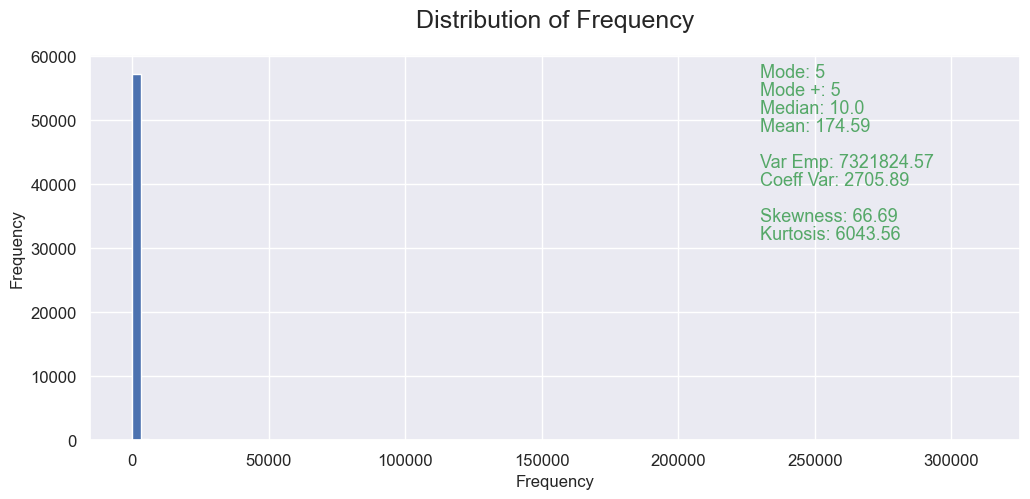

66.69

In [19]:
df = df_freq.loc[df_freq['Frequency'] > 4, :]

display(df.describe())
hist_distrib(df, 'Frequency', 100, 2 , density=False)

# Disons entre 4 et 10 (pour la frequence min) ?
# = on supprime entre 78 et 88% des tokens ! (calculs cellule suivante)
# Cela va creer du vide, à verifier ensuite


In [20]:
# Mots rares

# Count tags with frequency less than 2
tokens_below_2 = sum(1 for frequency in sorted_token_frequencies.values() if frequency < 2)
print(f'Fréquence == 1 : {tokens_below_2} tokens.')

# Environ 46% des tokens (presque la moitié) sont des hapax, ils n'apparaissent qu'une seule fois.
# Ces mots ne peuvent donc pas aider à la compréhension par le contexte.

# On sait par le describe que + de 75% des tokens ont une frequence <= 4.
# On peut le confirmer :
# 212657/270412=0.786

tokens_below_4 = sum(1 for frequency in sorted_token_frequencies.values() if frequency <= 4)
print(f'Fréquence <= 4 : {tokens_below_4} tokens.')

# Count tags with frequency less than 10
tokens_below_10 = sum(1 for frequency in sorted_token_frequencies.values() if frequency < 10)
print(f'Fréquence <= 10 : {tokens_below_10} tokens.')

# + de 88% des tokens apparaissent - de 10 fois ds tt le corpus.
# On sait par le deuxieme describe() que seuls 5% des tokens ont une frequence > 27.

# Count tags with frequency less than 27
tokens_below_27 = sum(1 for frequency in sorted_token_frequencies.values() if frequency < 10)
print(f'Fréquence <= 10 : {tokens_below_10} tokens.')
# 95%

tokens_hapax = [token for token, frequency in list(sorted_token_frequencies.items()) if frequency == 1]
tokens_rares = [token for token, frequency in list(sorted_token_frequencies.items()) if frequency <= 4]

# Notons qu'en supprimant les tokens rares, on va au passage implicitement nettoyer
# bcp de tokens inutiles (et pas toujours faciles à cibler directement) :
# erreurs typo, nombreux tokens numériques, etc...


Fréquence == 1 : 125518 tokens.
Fréquence <= 4 : 212657 tokens.
Fréquence <= 10 : 239241 tokens.
Fréquence <= 10 : 239241 tokens.


### 2.6 Stopwords


In [21]:
# Get a set of English stopwords from NLTK
stopwords = set(nltk.corpus.stopwords.words('english'))
print(len(stopwords), '\n')

important_tokens = [token for token in all_tokens if token not in stopwords]
print(len(important_tokens), '\n')
# + d'un quart de nos tokens appartiennent à la liste de stopwords (179 mots) !

# Display the first 50 items that are not stopwords, in the token frequencies dictionary
for token, frequency in list(sorted_token_frequencies.items())[:200]:
    if token in important_tokens:
        print(f"{token}: {frequency}")

# Il y a encore bcp de mots très communs. Pas sûr où placer le seuil.
# Le barplot était + parlant.


179 

7237651 

0: 91350
1: 77595
2: 47996
java: 45597
using: 38379
n: 36359
error: 35901
android: 35687
org: 34579
file: 31942
class: 31621
3: 31248
get: 30312
new: 30126
code: 27469
string: 26351
data: 26208
com: 26177
use: 25988
name: 25854
app: 25591
public: 25286
like: 24546
4: 24015
id: 22729
c: 22601
return: 21480
5: 20050
function: 19195
import: 18979
http: 18888
type: 17451
want: 17392
user: 17296
version: 16792
test: 16485
value: 16477
run: 16310
would: 16034
set: 15696
server: 15305
true: 15171
js: 14900
way: 14809
one: 14436
7: 14409
var: 14126
method: 13948
application: 13643
x: 13641
10: 13626
8: 13576
build: 13504
text: 13389
following: 13318
6: 13187
lib: 13117
web: 12916
project: 12885
self: 12765
tried: 12644
system: 12521
int: 12509
e: 12076
need: 12012
div: 11934
object: 11885
trying: 11774
line: 11695
add: 11640
work: 11478
python: 11405
view: 11327
problem: 11113
json: 11030
api: 10923
springframework: 10905
request: 10815
example: 10782
also: 10754
void: 10746
ti

In [22]:
# About these thresholds :

# lim_max could be a bit lower, maybe around 35 000
# But some important words appear between 35 000 and 50 000
# ex: java, the second most frequent tag (see 3.3)

# lim_min could probably be higher
# ask mentor

# Ici je me complique bien la vie en conservant deux seuils
# ça alourdit ce notebook
# mais c'est utile pour les tests
#

def get_forbidden_tokens(lim_max=50000, lim_min=4):
    """
    Get a set of forbidden tokens based on frequency thresholds and stop words.

    Parameters:
    - lim_max (int, optional): The upper frequency limit for tokens. Tokens with a frequency
      equal to or above this limit will be considered too frequent. Default is 50000.
    - lim_min (int, optional): The lower frequency limit for tokens. Tokens with a frequency
      equal to or below this limit will be considered too rare. Default is 4.

    Returns:
    set: A set containing forbidden tokens, which includes stop words, tokens exceeding
    the upper frequency limit, and tokens falling below the lower frequency limit.
    """
    too_frequent_tokens = [token for token, frequency in list(sorted_token_frequencies.items()) if frequency >= lim_max]
    too_rare_tokens = [token for token, frequency in list(sorted_token_frequencies.items()) if frequency <= lim_min]

    forbidden = set(stopwords)
    forbidden.update(too_frequent_tokens)
    forbidden.update(too_rare_tokens)

    return forbidden

# forbidden = get_forbidden_tokens(lim_min=4) # very low frequency (=80% des tokens)
# forbidden_f10_90p = get_forbidden_tokens(lim_min=10) # low frequency (=90%)
forbidden = get_forbidden_tokens(lim_min=27) # moderate frequency (=95%)


In [23]:
def preprocess_2_remove_stopwords_frequent_rare(liste_tokens, forbidden_list=forbidden):
    """
    Remove stopwords, tokens exceeding frequency thresholds, and tokens falling below
    frequency thresholds from a list of tokens.

    Parameters:
    - liste_tokens (list): The input list of tokens to be processed.
    - forbidden_list (set): A set of forbidden tokens, which includes stop words,
      tokens exceeding upper frequency limits, and tokens falling below lower frequency limits.

    Returns:
    list: A filtered list of tokens that excludes stop words, tokens exceeding upper frequency limits,
    and tokens falling below lower frequency limits.
    """
    filtered_list = [token for token in liste_tokens if token not in forbidden_list]

    return filtered_list


# Apply the preprocessing function to title, filtering  rare tokens
raw_questions_tags['title_tokens_no_stopwords'] = raw_questions_tags['title_tokens'].parallel_apply(
    lambda x: preprocess_2_remove_stopwords_frequent_rare(x))

raw_questions_tags['nb_tokens_title_no_stopwords'] = raw_questions_tags['title_tokens_no_stopwords'].apply(len)


In [24]:
# Apply the preprocessing function to body, filtering rare tokens
raw_questions_tags['body_tokens_no_stopwords'] = raw_questions_tags['body_tokens'].parallel_apply(
    lambda x: preprocess_2_remove_stopwords_frequent_rare(x))

raw_questions_tags['nb_tokens_body_no_stopwords'] = raw_questions_tags['body_tokens_no_stopwords'].apply(len)


In [25]:
raw_questions_tags.describe()

# On a en effet des valeurs à 0, pour la premiere fois (dans les titres).


,CreationDate,nb_tokens_title,nb_tokens_body,nb_tokens_title_no_stopwords,nb_tokens_body_no_stopwords
count,50000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2015-02-23 09:48:58.933900032,9.363800,208.716080,6.048160,125.593500
min,2011-05-23 20:00:57,1.000000,13.000000,0.000000,4.000000
25%,2013-01-03 00:42:30.500000,7.000000,89.000000,4.000000,47.000000
50%,2014-08-26 23:41:22,9.000000,143.000000,6.000000,79.000000
75%,2016-12-27 02:23:45,11.000000,239.000000,7.000000,139.000000
max,2023-10-02 11:07:45,33.000000,4852.000000,29.000000,4142.000000
std,NaN,3.678146,243.426177,2.387366,174.347732


In [26]:
# Combien ?

print(raw_questions_tags.loc[raw_questions_tags['nb_tokens_title_no_stopwords'] == 0, :].shape[0])

# Pas tant que ça


39


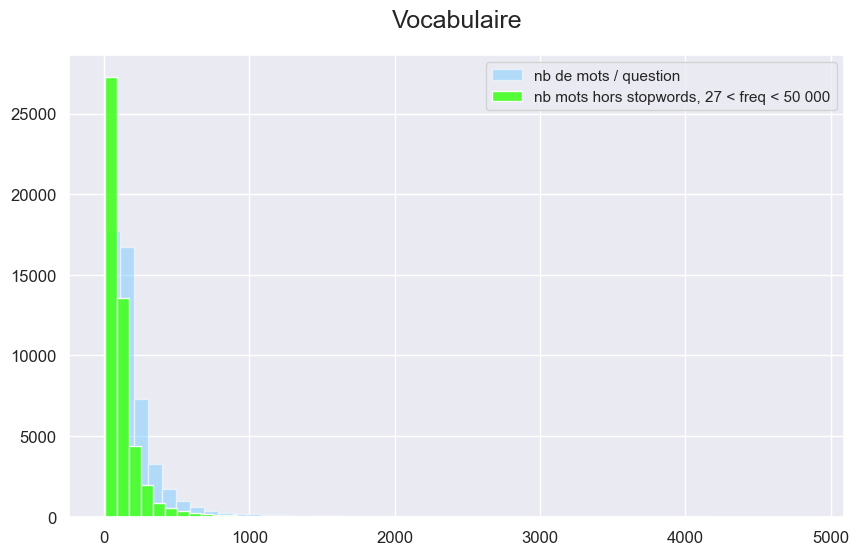

In [27]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting 'nb_mots'
raw_questions_tags['nb_tokens_body'].hist(density=False, bins=50, ax=ax, color='#7cf', alpha=0.5, label='nb de mots / question')

# Plotting 'nb_mots non stopwords'
raw_questions_tags['nb_tokens_body_no_stopwords'].hist(density=False, bins=50, color='#4f2', ax=ax,
                                                          alpha=0.9, label='nb mots hors stopwords, 27 < freq < 50 000')

plt.title('Vocabulaire', pad=20, fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ax.legend()
plt.show()


In [41]:
# Do we still have words that are only one character ?

shorts = set([])

def check_short_tokens(token_set, length):
    short_tokens = set([token for token in token_set if len(token) <= length])
    return short_tokens

shorts.update(raw_questions_tags['body_tokens_no_stopwords'].parallel_apply(
    lambda x: check_short_tokens(set(x), 100)))

print(len(shorts))
print(shorts)


TypeError: unhashable type: 'set'

### 2.7 Lemmatization + filtrage syntaxique


In [ ]:
# test
lemmatizer = WordNetLemmatizer()
words = ['John', 'houses', "running", 'ran', "better", "happiest", '62', '2nd', 'gdsasgsaggd']
print(nltk.pos_tag(words))

lemmas = [lemmatizer.lemmatize(word, pos='v') for word in words]
print(lemmas)

lemmas = [lemmatizer.lemmatize(word, pos='n') for word in words]
print(lemmas)

lemmas = [lemmatizer.lemmatize(word, pos=wordnet.ADJ) for word in words]
print(lemmas)


In [ ]:
# + filtrage implicite du vocabulaire non-anglais ?
# En fait non, les mots inconnus sont conservés, inchangés.

# Lemmatization tends to be more accurate but can be slower than stemming.
# On a utilisé le stemming en français, dans le cours openclassrooms
# Utilisons la lemmatisation ici, + appropriée pour notre objectif
# (extraire le sens important, le thème, pour proposer des mots-clés, topics, tags)
# On peut aussi profiter de l'analyse grammaticale (POS) pour
# conserver uniquement les mots les plus "importants" dans la phrase, les noms et les verbes.

# On veut garder les noms et les verbes
# On veut éliminer tout ce qui est identifié autrement : det, adj, adv, conj, pronoms, numerals, etc..
# Probleme : le reste, les mots auxquels le modèle utilisé par nltk n'arrive pas à assigner
# un pos_tag. Le choix de les conserver ou pas n'est pas évident. Point de vue nettoyage c'est très tentant,
# mais peut-être trop radical. Des mots importants, tags potentiels, vont disparaitre.
# Testons :

# When nltk.pos_tag encounters a word for which it cannot determine a part-of-speech tag, it typically
# assigns the tag 'NN' (noun, singular or mass) by default.
# Ce qui ne nous arrange pas, du coup on ne peut pas profiter de l'analyse syntaxique pour filtrer les mots inconnus.
# Il faut le faire avant, ou autrement (spacy par exemple, voir partie 4)

def preprocess_3_lemmatize(tokens):
    """
    Lemmatize tokens based on their part-of-speech (POS) tags, filtering certain POS categories.

    Parameters:
    - tokens (list): A list of tokens to be lemmatized.

    Returns:
    list: A list of lemmatized tokens after filtering based on POS tags. Verbs (POS starting
    with 'V') and nouns (POS starting with 'N') are lemmatized using WordNet lemmatizer.
    Other tokens are excluded from the output.
    """
    # lemmatizer = WordNetLemmatizer()

    # Get part of speech for each token
    pos_tags = nltk.pos_tag(tokens)
    lemmatized_tokens = []

    for token, pos_tag in pos_tags:
        # ! Uncommenting next line may crash the cell
        # print(f"Token: {token}, POS Tag: {pos_tag}")
        if pos_tag.startswith('V'):
            # On garde
            lemmatized_tokens.append(lemmatizer.lemmatize(token, pos='v'))
            # Returns the input word unchanged if it cannot be found in WordNet.
        elif pos_tag.startswith('N'):
            # On garde
            try:
                lemmatized_tokens.append(lemmatizer.lemmatize(token, pos='n'))
            except Exception as e:
                print(f"Error lemmatizing verb {token}: {e}")
        # Sinon on supprime

    return lemmatized_tokens


raw_questions_tags['title_lemms'] = raw_questions_tags['title_tokens_no_stopwords'].parallel_apply(
    lambda x: preprocess_3_lemmatize(x))

raw_questions_tags['nb_lemms_title'] = raw_questions_tags['title_lemms'].apply(len)


In [ ]:
raw_questions_tags['body_lemms'] = raw_questions_tags['body_tokens_no_stopwords'].parallel_apply(
    lambda x: preprocess_3_lemmatize(x))

raw_questions_tags['nb_lemms_body'] = raw_questions_tags['body_lemms'].apply(len)


### 2.8 Lemmatisation / filtrage : résultats étonnants


In [ ]:
filtered_columns_title = raw_questions_tags.filter(like='title')
display(filtered_columns_title)

display(raw_questions_tags.describe())

# interessant
# pourquoi "werkzeug" disparait pdt la lemmatisation ?? (ligne 1)
print(nltk.pos_tag(["werkzeug"]))
# mot inconnu ou nom commun, donc taggé "NN"
# devrait rester
# Tout a l'air normal /lemmatisation des noms et verbes (ex: upgrade, difference)
# je vois qq adjectifs (ex:True) et nums (101) disparaitre.

# a part werkzeug, ce token je ne comprends pas ??
print(lemmatizer.lemmatize("werkzeug", pos='n'))
# jdk aussi (ligne 2)
print(nltk.pos_tag(["jdk"]))
# encore + bizarre. conservé ds 1 cas mais pas ds l'autre ???
# et ce n'est pas en raison de la frequence, comme pour stylecop + bas...


### 2.9 Test : fonctionnement du POS tagger


In [ ]:
pos_tags = nltk.pos_tag(['compilation', 'error', 'upgrade', 'jdk', 'member'])
lemmatized_tokens = []

for token, pos_tag in pos_tags:
    # ! Uncommenting next line may crash the cell
    print(f"Token: {token}, POS Tag: {pos_tag}")
    if pos_tag.startswith('V'):
        # On garde
        lemmatized_tokens.append(lemmatizer.lemmatize(token, pos='v'))
        # Returns the input word unchanged if it cannot be found in WordNet.
    elif pos_tag.startswith('N'):
        # On garde
        try:
            lemmatized_tokens.append(lemmatizer.lemmatize(token, pos='n'))
        except Exception as e:
            print(f"Error lemmatizing verb {token}: {e}")
    # Sinon on supprime

print(lemmatized_tokens)

# upgrade un adjectif ??
# OK je commence à comprendre...
# nltk aussi utilise des modeles entraines derriere certaines fonctions maintenant ??
# dont le pos tagger, apparemment.
# du coup le tagging est influencé par le contexte...

# Je croyais que spacy utilisait du machine learning, mais pas nltk.
# Je croyais connaitre nltk, mais ce module a bien evolue depuis la derniere fois que je m'en suis servi !

# wow c'etait particulier a comprendre ce bug
# pas evident a trouver deja, j'ai failli le rater
# (bon exemple de fonction ou qq test unitaires peuvent etre tres utiles)
# ensuite facile de trouver la partie du code qui pose probleme, mais sans l'exemple de jdk
# (mm token traite differemment par la mm fonction) ca aurait pu etre compliqué,
# je n'avais pas compris que le taggeur pouvait changer d'avis !
# that was fun

# du coup ca change l'ordre des etapes, il vaut mieux proceder a la lemmatisation des le debut,
# sur du texte naturel,
# et filtrer ensuite les stopwords et tokens trop frequents / trop rares.
# = inverser les etapes 2 et 3


### 2.10 Modification de l'ordre prévu


In [ ]:
# Repartons sur un nouveau dataframe "propre"
questions_tags = raw_questions_tags[['CreationDate',
                                     'title', 'body', # string d'origine, no html
                                     'title_tokens', 'nb_tokens_title',
                                     'body_tokens', 'nb_tokens_body', 'tags']].copy()


In [ ]:
# Lemmatization du texte presque "naturel" (absence de majuscules et ponctuation)

questions_tags['title_lemms'] = questions_tags['title_tokens'].parallel_apply(
    lambda x: preprocess_3_lemmatize(x))

questions_tags['nb_lemms_title'] = questions_tags['title_lemms'].apply(len)


In [ ]:
questions_tags['body_lemms'] = questions_tags['body_tokens'].parallel_apply(
    lambda x: preprocess_3_lemmatize(x))

questions_tags['nb_lemms_body'] = questions_tags['body_lemms'].apply(len)


In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting 'nb_tokens'
questions_tags['nb_tokens_body'].hist(density=False, bins=50, ax=ax, color='#7cf', alpha=0.9, label='nb de tokens / question')

# Plotting 'nb lemms'
questions_tags['nb_lemms_body'].hist(density=False, bins=50, color='#3f5', ax=ax,
                                                          alpha=1.0, label='nb lemms (noms et verbes)')

plt.title('Vocabulaire (questions)', pad=20, fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ax.legend()
plt.show()


In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))

# Mm chose pour les titres
questions_tags['nb_tokens_title'].hist(density=False, bins=30, color='#7cf', ax=ax,
                                                          alpha=0.9, label='nb tokens / titre')

# Plotting 'lemms'
questions_tags['nb_lemms_title'].hist(density=False, bins=20, color='#3f5', ax=ax,
                                                          alpha=1.0, label='nb lemmes / titre')

plt.title('Vocabulaire (titres)', pad=20, fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ax.legend()

plt.show()


In [ ]:
# re filtre frequence + stopwords

questions_tags['title_lemms_freq'] = questions_tags['title_lemms'].parallel_apply(
    lambda x: preprocess_2_remove_stopwords_frequent_rare(x))

questions_tags['nb_lemms_title_freq'] = questions_tags['title_lemms_freq'].apply(len)


In [ ]:
questions_tags['body_lemms_freq'] = questions_tags['body_lemms'].parallel_apply(
    lambda x: preprocess_2_remove_stopwords_frequent_rare(x))

questions_tags['nb_lemms_body_freq'] = questions_tags['body_lemms_freq'].apply(len)


### 2.11 tokens (lemms) uniques


In [ ]:
# On aurait pu procéder à cette étape bien plus tôt (juste après l'étude de fréquences)
# et ainsi économiser du temps de calcul et de l'espace mémoire, mais on se garde ainsi
# la possibilité de tester notre LDA (notebook 3) sur un bag-of-words "classique".

# Au final, le filtrage / la frequence a ete repousse juste avant cette etape.

def preprocess_4_keep_uniques_only(liste_tokens):
    """
    Keep only unique tokens in a list, removing duplicates.

    Parameters:
    - liste_tokens (list): A list of tokens.

    Returns:
    list: A list containing only unique tokens, preserving the order of the first occurrence.
    """
    seen_tokens = set()
    unique_tokens = []

    for token in liste_tokens:
        if token not in seen_tokens:
            seen_tokens.add(token)
            unique_tokens.append(token)

    return unique_tokens

# Apply the preprocessing function to title
questions_tags['title_lemms_uniques'] = questions_tags['title_lemms_freq'].parallel_apply(preprocess_4_keep_uniques_only)

# Count
questions_tags['nb_lemms_uniques_title'] = questions_tags['title_lemms_uniques'].apply(len)


In [ ]:
# and body
questions_tags['body_lemms_uniques'] = questions_tags['body_lemms_freq'].parallel_apply(preprocess_4_keep_uniques_only)

questions_tags['nb_lemms_uniques_body'] = questions_tags['body_lemms_uniques'].apply(len)

# + long pour les titres ??


In [ ]:
display(questions_tags.describe())

display(questions_tags)

# Ca a l'air pas mal


In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting 'nb_mots'
questions_tags['nb_tokens_body'].hist(density=False, bins=50, ax=ax, color='#7cf', alpha=0.9, label='nb de tokens / question')

# Plotting 'nb_mots non stopwords'
questions_tags['nb_lemms_body'].hist(density=False, bins=40, color='#4f6', ax=ax,
                                                          alpha=0.6, label='nb lemmes, verbes + noms')

# Plotting 'lemms'
questions_tags['nb_lemms_body_freq'].hist(density=False, bins=30, color='#eb1', ax=ax,
                                                          alpha=1.0, label='nb_lemms uniques, filtre soft')

# Plotting 'lemms uniques'
# = smallest dataset obtained with nltk
questions_tags['nb_lemms_uniques_body'].hist(density=False, bins=20, color='#f55', ax=ax,
                                                          alpha=1.0, label='nb_lemms_uniques')

plt.title('Vocabulaire', pad=20, fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ax.legend()

plt.show()

# On voit une petite différence !


In [ ]:
# Extract tokens from the 'lemms_uniques' column
all_lemms_soft = set(([token for tokens_list in questions_tags['title_lemms_uniques'] for token in tokens_list]
                 + [token for tokens_list in questions_tags['body_lemms_uniques'] for token in tokens_list]))

print(len(all_lemms_soft))
# Notre corpus a été divisé par 30 environ.


In [ ]:
# Corpus de départ
graphs_analyse_uni(questions_tags, 'nb_tokens_body', bins=50, r=2, density=True)


In [ ]:
# Corpus d'arrivée
graphs_analyse_uni(questions_tags, 'nb_lemms_uniques_body', bins=50, r=2, density=True)

# Moyenne divisée par 4-5


### 2.12 Explorer le corpus obtenu


In [ ]:
# Affichons 20 questions au hasard (+ les tags)
display(questions_tags.sample(20))


In [ ]:
# Pistes restantes

# Le preprocessing de nos questions est assez satisfaisant, il répond à nos objectifs.
# Pour aller + loin, on pourrait par exemple examiner plus attentivement les valeurs numériques,
# les dates, URLs, adresses Email, noms propres, etc...

# Ces traitements plus avancés peuvent vite devenir horriblement compliqués
# avec un pur traitement nltk + regex, sans être jamais complètement satisfaisants.
# Filtrer les dates par exemple, juste les dates... C'est déjà un travail colossal à cause des
# (très) nombreux formats possibles.
# Identifier les noms propres... c'est simplement impossible sans machine learning.

# Nous allons donc en profiter pour tester spacy, qui est orienté objet et utilise différents modèles
# préentrainés. (cf partie 4)

# Avant cela, intéressons-nous aux tags, qui sont nos futures targets.


## 3 EDA et preprocessing des targets


### 3.1 Convertion (string to list)


In [ ]:
def convert_tags_string_to_list(tags_string):
    """
    Convert a string representation of tags into a list of tags.

    Parameters:
    - tags_string (str): A string containing tags in the format "<tag1><tag2>...<tagN>".

    Returns:
    list: A list of tags extracted from the input string.
    """
    # just in case
    tags_string = tags_string.lower()

    # Split tags by '><'
    tags_list = tags_string.split('><')

    # Remove angle brackets from the first and last tag
    tags_list[0] = tags_list[0][1:]
    tags_list[-1] = tags_list[-1][:-1]

    return tags_list


# Apply the preprocessing function to the 'tags' column
questions_tags['tags_list'] = questions_tags['tags'].apply(convert_tags_string_to_list)

display(questions_tags[['tags', 'tags_list']].head(10))


In [ ]:
questions_tags['nb_tags'] = questions_tags['tags_list'].apply(len)
questions_tags['nb_tags'].describe()

# min : 5
# max : 6
# Un intervalle plutôt réduit.


### 3.2 Corpus des tags, Doublons éventuels


In [ ]:
all_tags = [tag for tags in questions_tags['tags_list'] for tag in tags]
print(f'Il y a {len(all_tags)} tags au total. \n')
print(f'Il y a {len(set(all_tags))} tags différents. \n')

# Au cas où il y aurait des doublons ds les tags
questions_tags['tags_uniques'] = questions_tags['tags_list'].apply(preprocess_4_keep_uniques_only)

# display(questions_tags)

# Fréquence
# Factoriser ?
tag_frequencies_dict = {}
for tag in all_tags:
    tag_frequencies_dict[tag] = tag_frequencies_dict.get(tag, 0) + 1

# Sort the dictionary items by values in descending order
sorted_tag_frequencies = dict(sorted(tag_frequencies_dict.items(), key=lambda item: item[1], reverse=True))

# Display the first 50 items in the tag frequencies dictionary
for tag, frequency in list(sorted_tag_frequencies.items())[:50]:
    print(f"{tag}: {frequency}")

# 250 000 tags (différents) !
# Ca repond a la question : est-ce qu'un humain pourrait facilement faire cette tache.
# Il faudrait déjà connaitre ts les tags possibles... Pas évident.

# Le tag le plus présent est python
# Est-ce qu'il y a plus de codeurs en python qu'en javascript ?
# Peut-être. Pas sûr.
# Est-ce qu'on va sur stack overflow plus souvent quand on fait du python ?
# Je dirais que oui. Il y a tjs de nveaux modules à découvrir en python !

# Classement intéressant !


### 3.3 Frequences des tags


In [ ]:
# Extract tags and frequencies
tags = list(sorted_tag_frequencies.keys())
frequencies = list(sorted_tag_frequencies.values())

# Plot
plt.figure(figsize=(12, 6))
plt.bar(tags[:100], frequencies[:100], color='skyblue')
plt.xlabel('Tags')
plt.ylabel('Frequency')
plt.title('Top 50 Tag Frequencies')
plt.xticks(rotation=90, ha='right', fontsize=8)  # Rotate x-axis labels for better readability
plt.show()


### 3.4 Les 20 tags les + frequents


In [ ]:
# + d'un tiers des question concernent python, js ou java.

# Faisons un top 20
df_freq = pd.DataFrame({'Tag': tags, 'Frequency': frequencies})

# Display the DataFrame
display(df_freq.head(20))

# plot a pie
colors = generate_random_pastel_colors(20)

fig, ax = plt.subplots(figsize=(10, 10))

patches, texts, autotexts = plt.pie(x=df_freq['Frequency'][:20], autopct='%1.1f%%',
    startangle=-30, labels=df_freq['Tag'][:20], textprops={'fontsize':11, 'color':'#000'},
    labeldistance=1.25, pctdistance=0.85, colors=colors)

plt.title(
label='20 most frequent Tags',
fontdict={"fontsize":17},
pad=20
)

for text in texts:
    # text.set_fontweight('bold')
    text.set_horizontalalignment('center')

# Customize percent labels
for autotext in autotexts:
    autotext.set_horizontalalignment('center')
    autotext.set_fontstyle('italic')
    autotext.set_fontsize('10')

#draw circle
centre_circle = plt.Circle((0,0),0.7,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.show()


### 3.5 Tags rares


In [ ]:
df_freq.describe()


In [ ]:
# rappel : 16231 tags différents

# Comme pour les autres tokens, la majorité des tags sont rares
# d'apres le describe(), 50% des tags n'apparaissent qu'une ou deux fois.
# difficile d'entrainer un modele pour eux

# 75% des tags apparaissent - de 6 fois

# Count tags with frequency less than 10
nb_tags_below_10 = sum(1 for frequency in sorted_tag_frequencies.values() if frequency <= 10)
print(nb_tags_below_10)
# Environ 3000 tags ont une frequence > 10

# voire tres rares
# tags hapax (1 seule occurence)

# Count tags with frequency less than 2
nb_tags_below_2 = sum(1 for frequency in sorted_tag_frequencies.values() if frequency < 2)
print(nb_tags_below_2)
# (= + d'un tiers du corpus de tags)

# On les supprime ?
# seuil ? qq part entre 6 et 300 ?
# On va créer des targets vides, à vérifier

# pour les modeles que nous allons tester, il est peu probable qu'on essaie de predire + que
# qq dizaines de tags, pour des raisons techniques : probablement pas optimal
# et métier : difficile de relier manuellement les topics générés par une LDA par exemple
# aux tags préexistants, encore + difficile s'il y en a des centaines !


In [ ]:
# 100 tags les + frequents

top_101_tags = df_freq[['Tag', 'Frequency']][:101].copy()
display(top_101_tags.tail())

# frequence > 330
# >= 332

list_top_100_tags = df_freq['Tag'][:100].tolist()
print(len(list_top_100_tags))
print(list_top_100_tags)


In [ ]:
# 20 tags les + frequents

top_21_tags = df_freq[['Tag', 'Frequency']][:21].copy()
display(top_21_tags.tail())

# frequence >
# >=

list_top_20_tags = df_freq['Tag'][:20].tolist()
print(len(list_top_20_tags))
print(list_top_20_tags)


In [ ]:
def keep_most_frequent_tags(list_tags, lim=100):
    """
    Keep only the n most frequent tags (default 100).

    Parameters:
    - liste_tokens (list): The input list of tokens to be processed.
    - forbidden_list (set): A set of forbidden tokens, which includes stop words,
      tokens exceeding upper frequency limits, and tokens falling below lower frequency limits.

    Returns:
    list: A filtered list of tokens that excludes stop words, tokens exceeding upper frequency limits,
    and tokens falling below lower frequency limits.
    """
    mandatory_list = df_freq['Tag'][:lim].tolist()
    filtered_list = [token for token in list_tags if token in mandatory_list]

    return filtered_list


questions_tags['tags_100'] = questions_tags['tags_list'].apply(
    lambda x: keep_most_frequent_tags(x, 100)
)

questions_tags['nb_tags_100'] = questions_tags['tags_100'].apply(len)


In [ ]:
questions_tags['tags_20'] = questions_tags['tags_list'].apply(
    lambda x: keep_most_frequent_tags(x, 20)
)

questions_tags['nb_tags_20'] = questions_tags['tags_20'].apply(len)


In [ ]:
questions_tags['tags_10'] = questions_tags['tags_list'].apply(
    lambda x: keep_most_frequent_tags(x, 10)
)

questions_tags['nb_tags_10'] = questions_tags['tags_10'].apply(len)


In [ ]:
questions_tags.describe()

print(questions_tags.loc[questions_tags['nb_tags_100'] == 0, :].shape[0])
# On perd 2500 lignes sur 50 000 avec 100 tags
# Largement acceptable

print(questions_tags.loc[questions_tags['nb_tags_20'] == 0, :].shape[0])
# On perd  lignes 11 000 lignes sur 50 000 avec 20 tags
# - 20 %

print(questions_tags.loc[questions_tags['nb_tags_10'] == 0, :].shape[0])
# On perd 14 000 lignes sur 50 000 avec 10 tags
# - 30 %


### 3.6 WordCloud


In [ ]:
def show_cloud(list):
    cloud = WordCloud(background_color='white',
                    stopwords=[],
                    max_words=50).generate(" ".join(list))
    plt.imshow(cloud)
    plt.axis('off')
    plt.show()


show_cloud(all_tags)
# Pourquoi python tout petit ?? C le tag le + frequent !


In [ ]:
# analyse multi
# Nous allons rapidement visualiser les wordclouds des 5 tags les + fréquents.

most_frequent_tags = tags[:5]
print(most_frequent_tags)

subsets = dict()

for t in most_frequent_tags:
    subsets[t] = [tag for tags in questions_tags['tags_list'] for tag in tags if t in tags]


In [ ]:
for subset in subsets:
    print(f'Tag : {subset}')
    show_cloud(subsets[subset])


In [ ]:
# Sans les répétitions :

for subset in subsets:
    print(f'Tag : {subset}')
    show_cloud(set(subsets[subset]))

# C'est plus parlant !


In [ ]:
# Sur la feature filtrée

subsets = dict()

for t in most_frequent_tags:
    subsets[t] = [tag for tags in questions_tags['tags_100'] for tag in tags if t in tags]

for subset in subsets:
    print(f'Tag : {subset}')
    show_cloud(set(subsets[subset]))

# Les differents tags sont moins bien caracterises,
# mais restent différentiés, reconnaissables.


In [ ]:
subsets = dict()

for t in most_frequent_tags:
    subsets[t] = [tag for tags in questions_tags['tags_20'] for tag in tags if t in tags]

for subset in subsets:
    print(f'Tag : {subset}')
    show_cloud(set(subsets[subset]))

# OK mais tt commence à se ressembler


## 4 Spacy


In [ ]:
nlp = spacy.load("en_core_web_sm")


### 4.1 Test : use spacy as tokenizer


In [ ]:
def tokenize_with_spacy(text):
    doc = nlp(text)

    return [token.text for token in doc]


# Apply to original 'title' column
questions_tags['title_spacy_tokens'] = questions_tags['title'].parallel_apply(
    lambda x: tokenize_with_spacy(x))


In [ ]:
questions_tags['nb_tokens_title_spacy'] = questions_tags['title_spacy_tokens'].apply(len)


In [ ]:
# Pour comparer avec nltk + regex
# questions_tags['body_spacy_tokens'] = questions_tags['body'].parallel_apply(tokenize_with_spacy)


In [ ]:
# questions_tags['nb_tokens_body_spacy'] = questions_tags['body_spacy_tokens'].apply(len)


In [ ]:
display(questions_tags.head())


In [ ]:
# Un peu tot pour l'etude de frequence, il reste trop de "bruit"

# Extract tokens from the 'tokens_uniques' column
# all_tokens_spacy = ([token for tokens_list in questions_tags['title_spacy_tokens'] for token in tokens_list]
#                  + [token for tokens_list in questions_tags['body_spacy_tokens'] for token in tokens_list])

# print(f'Nombre de tokens (en tout) : {len(all_tokens_spacy)}')
# print(f'Nombre de tokens (différents) : {len(set(all_tokens_spacy))}', '\n')

# Rappel : avec nltk + regex tokenizer, on avait
# + d'un million de "mots" (tokens),
# dont environ 270 000 différents

# Ici avec Spacy, on a 14 millions de tokens en tout (découpage plus fin)
# pour un corpus deux fois plus important. Impressionnant !


### 4.2 Preprocessing with spacy


In [ ]:
# pour la suppression des stopwords et tokens très fréquents / très rares

forbidden.update(nlp.Defaults.stop_words) # moderate frequency (=95%)

print(len(nlp.Defaults.stop_words))
print(nlp.Defaults.stop_words)


In [ ]:
def do_everything_with_spacy(text, forbidden_list=forbidden):
    doc = nlp(text)

    # Filter out punctuation tokens, and tokens that are not nouns or verbs
    # Ici trop brutal ?
    nouns_and_verbs = [token for token in doc if not token.is_punct and token.pos_ in ('NOUN', 'VERB')]

    # Filter out common stop words from nouns and verbs
    important_tokens = [token.lemma_.lower() for token in nouns_and_verbs if token.text.lower() not in forbidden_list]

    # Additional filters for dates or other criteria can be added
    # but we already filtered non english words implicitely, by keeping only nouns and verbs

    return important_tokens


# Apply to original 'title' column
questions_tags['title_spacy'] = questions_tags['title'].parallel_apply(
    lambda x: do_everything_with_spacy(x, nlp.Defaults.stop_words))

# parfois + rapide que le simple tokenizer ??


In [ ]:
questions_tags['nb_lemms_title_spacy'] = questions_tags['title_spacy'].apply(len)


In [ ]:
# filtrage frequence + severe
# questions_tags['title_spacy_hard'] = questions_tags['title'].parallel_apply(
#     lambda x: do_everything_with_spacy(x, forbidden_f27_95p))


In [ ]:
# questions_tags['nb_lemms_title_spacy_hard'] = questions_tags['title_spacy_hard'].apply(len)


In [ ]:
pandarallel.initialize(progress_bar=True, nb_workers=8)

# Apply to original 'body' column (without html)
questions_tags['body_spacy'] = questions_tags['body'].parallel_apply(
    lambda x: do_everything_with_spacy(x, nlp.Defaults.stop_words))

# Environ 10-11 min sur 6 à 8 cores
# Merci encore pandarallel !


In [ ]:
pandarallel.initialize(progress_bar=False, nb_workers=6)

questions_tags['nb_lemms_body_spacy'] = questions_tags['body_spacy'].apply(len)


In [ ]:
# questions_tags['body_spacy_hard'] = questions_tags['body'].parallel_apply(
#     lambda x: do_everything_with_spacy(x, forbidden_f27_95p))


In [ ]:
# questions_tags['nb_lemms_body_spacy_hard'] = questions_tags['body_spacy_hard'].apply(len)


### 4.3 Frequences


In [ ]:
# Le corpus est tres different, notre etude de frequences nltk ne correspond plus
# On ne peut pas vraiment "comparer" les 2 corpus, les traitements n'étant pas exactement les mmes,
# Mais ça donne une idée.

# Extract tokens from the 'tokens_uniques' column
all_tokens_spacy = ([token for tokens_list in questions_tags['title_spacy'] for token in tokens_list]
                 + [token for tokens_list in questions_tags['body_spacy'] for token in tokens_list])

print(f'Nombre de tokens (en tout) : {len(all_tokens_spacy)}')
print(f'Nombre de tokens (différents) : {len(set(all_tokens_spacy))}', '\n')
# + de 3 millions de "mots" (tokens), (nltk x 1/3)
# dont environ 200 000 différents (nltk 270 000)
# sachant que les traitements ne sont pas les memes.
# Spacy a reduit le corpus en seulement qq instructions.
# Observons le résultat obtenu

# Calculate token frequencies using a loop
token_frequencies_dict_spacy = {}
for token in all_tokens_spacy:
    token_frequencies_dict_spacy[token] = token_frequencies_dict_spacy.get(token, 0) + 1

# Display the first 50 items in the token frequencies dictionary (not sorted yet)
for token, frequency in list(token_frequencies_dict_spacy.items())[:50]:
    print(f"{token}: {frequency}")


In [ ]:
# Sort the dictionary items by values in descending order
sorted_token_frequencies_spacy = dict(sorted(token_frequencies_dict_spacy.items(), key=lambda item: item[1], reverse=True))

# Display the first 50 items in the token frequencies dictionary
for token, frequency in list(sorted_token_frequencies_spacy.items())[:50]:
    print(f"{token}: {frequency}")

# Ce filtrage semble fonctionnel.
# le signe =, c'est considéré comme un nom ou un verbe ??


In [ ]:
# Visualisons

df_freq = pd.DataFrame(list(token_frequencies_dict_spacy.items()), columns=['Token', 'Frequency'])

# Sort the DataFrame by frequency in descending order
df_freq = df_freq.sort_values(by='Frequency', ascending=False)

print(df_freq.shape)
display(df_freq.describe())

df = df_freq[:200]

fig = px.bar(df, x='Token', y='Frequency', labels={'Token': 'Token', 'Frequency': 'Frequency'},
             title='Token Frequency Distribution', text='Frequency')
fig.update_xaxes(tickangle=90, tickmode='array', tickvals=df.index, ticktext=df['Token'])

# Show the plot
fig.show()

# Deux x + étalé que le corpus obtenu avec nltk
# (2 x + de tokens)


In [ ]:
print(token_frequencies_dict_spacy['java'])
# de 35 000 (nltk) à 2 000 (spacy) ??

# 2 "error" ??
print(token_frequencies_dict_spacy['error'])
display(df_freq.loc[df_freq['Frequency'] == 190018, :])

# OK mais probleme xticks ??


In [ ]:
df = df_freq.loc[df_freq['Frequency'] > 2, :]

display(df.describe())

# Par rapport au corpus des tokens apres filtrage spacy (environ 200 000 tokens),
# 1/16 des tokens (env 12 500) ont une frequence > 11

# avec nltk
# en filtrant N > 4 ("soft"), on gardait environ 20 % du corpus, soit 60 000 tokens.
# en filtrant N > 27 ("hard"), on gardait environ 5 % du corpus, soit 15 000 tokens.

# avec spacy
# on peut obtenir des corpus de tailles similaires (legerement inferieure)
# en filtrant N > 2 (soft), on garde environ 20 % du corpus, soit 50 000 tokens.
# N > 11 ("hard"), on garde environ 5 % du corpus, soit 10 000 tokens.

hist_distrib(df, 'Frequency', 100, 2 , density=False)
# La distribution avec spacy n'est pas aussi skewed que celle avec nltk,
# mais c'est sans doute dû au fait qu'il y avait plus de tokens à très haute frequence avec nltk
# a freq moyenne est ici de 80 avec spacy, elle était environ = 175 avec nltk (avant lemmatisation)


In [ ]:
def get_forbidden_tokens_spacy(lim_max=50000, lim_min=2):
    """
    Get a set of forbidden tokens based on frequency thresholds and stop words.

    Parameters:
    - lim_max (int, optional): The upper frequency limit for tokens. Tokens with a frequency
      equal to or above this limit will be considered too frequent. Default is 50000.
    - lim_min (int, optional): The lower frequency limit for tokens. Tokens with a frequency
      equal to or below this limit will be considered too rare. Default is 2.

    Returns:
    set: A set containing forbidden tokens, which includes stop words, tokens exceeding
    the upper frequency limit, and tokens falling below the lower frequency limit.
    """
    too_frequent_tokens = [token for token, frequency in list(sorted_token_frequencies_spacy.items()) if frequency >= lim_max]
    too_rare_tokens = [token for token, frequency in list(sorted_token_frequencies_spacy.items()) if frequency <= lim_min]

    forbidden = set(nlp.Defaults.stop_words)
    forbidden.update(too_frequent_tokens)
    forbidden.update(too_rare_tokens)

    return forbidden

forbidden_spacy = get_forbidden_tokens_spacy(lim_min=11) # moderate frequency (=95%)


In [ ]:
# Apply the preprocessing function to title, filtering very rare tokens only
questions_tags['title_spacy_freq'] = questions_tags['title_spacy'].parallel_apply(
    lambda x: preprocess_2_remove_stopwords_frequent_rare(x, forbidden_spacy))

questions_tags['nb_tokens_title_spacy_freq'] = questions_tags['title_spacy_freq'].apply(len)


In [ ]:
# Apply the preprocessing function to body, filtering very rare tokens only
questions_tags['body_spacy_freq'] = questions_tags['body_spacy'].parallel_apply(
    lambda x: preprocess_2_remove_stopwords_frequent_rare(x, forbidden_spacy))

questions_tags['nb_tokens_body_spacy_freq'] = questions_tags['body_spacy_freq'].apply(len)


### 4.4 Uniques only (set)


In [ ]:
# keep only uniques
questions_tags['title_lemms_uniques_spacy'] = questions_tags['title_spacy_freq'].parallel_apply(preprocess_4_keep_uniques_only)
questions_tags['nb_lemms_uniques_title_spacy'] = questions_tags['title_lemms_uniques_spacy'].apply(len)

questions_tags['body_lemms_uniques_spacy'] = questions_tags['body_spacy_freq'].parallel_apply(preprocess_4_keep_uniques_only)
questions_tags['nb_lemms_uniques_body_spacy'] = questions_tags['body_lemms_uniques_spacy'].apply(len)


In [ ]:
questions_tags.describe()


In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting 'lemms' (nouns and verbs)
questions_tags['nb_lemms_body_spacy'].hist(density=False, bins=50, color='#7cf', ax=ax,
                                                          alpha=0.9, label='nb_lemms_uniques (nltk)')

# Plotting 'tokens' (very low frequency filtered)
questions_tags['nb_tokens_body_spacy_freq'].hist(density=False, bins=40, color='#4f6', ax=ax,
                                                          alpha=0.9, label='nb_lemms_uniques (spacy)')

# Plotting 'lemms uniques', low  frequency filtered
# (= smallest dataset obtained with spacy)
questions_tags['nb_lemms_uniques_body_spacy'].hist(density=False, bins=20, color='#f55', ax=ax,
                                                          alpha=0.9, label='nb_lemms_uniques (spacy)')

plt.title('Vocabulaire', pad=20, fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ax.legend()
plt.show()

# Spacy c'est juste incroyable. Un nouveau monde de programmation !
# What a day to be alive !
# New nltk is also amazing. Both have ML functions.

### 4.5 Comparaison des corpus obtenus, nltk vs spacy


In [ ]:
# Quantité

# nltk
all_lemms_nltk = set(([token for tokens_list in questions_tags['title_lemms_uniques'] for token in tokens_list]
                 + [token for tokens_list in questions_tags['body_lemms_uniques'] for token in tokens_list]))

print(len(all_lemms_nltk))
# Notre corpus d'origine (270 000 tokens) a été divisé par 20+ environ.

# spacy
all_lemms_spacy = set(([token for tokens_list in questions_tags['title_lemms_uniques_spacy'] for token in tokens_list]
                 + [token for tokens_list in questions_tags['body_lemms_uniques_spacy'] for token in tokens_list]))

print(len(all_lemms_spacy))
# Notre corpus d'origine (200 000 tokens) a été divisé par 20+ environ.


In [ ]:
# Vérifier qu'on n'a pas été trop aggressifs ?
# J'ai peur que certains tags aient disparu, s'ils ne sont pas ds le dictionnaire

display(questions_tags.sample(20, random_state=42))
# brutal en effet !
# python n'est pas dans le dictionnaire ? (ligne 4)

# ou alors il appartient au mots interdits ?
token_frequencies_dict['python']
# nope


In [ ]:
# Difficile de lire dans le dataframe
# Observons qq questions + en detail

# Utilisons d'abord un preprocessing large
# = avec repetitions

df = questions_tags.sample(20, random_state=42)

for index in df.index:
    print(f'Question {index}', '\n')

    print('Texte d\'origine (no html :)')
    print(df.loc[df.index == index, ['body']].values[0], '\n')

    nb_nltk = df.loc[df.index == index, ['nb_lemms_body_freq']].values[0]
    print(f'Preprocessed using nltk ({nb_nltk} tokens) :')
    print(df.loc[df.index == index, ['body_lemms_freq']].values[0], '\n')

    nb_spacy = df.loc[df.index == index, ['nb_tokens_body_spacy_freq']].values[0]
    print(f'Preprocessed using spacy ({nb_spacy} tokens) :')
    print(df.loc[df.index == index, ['body_spacy_freq']].values[0], '\n')

# Les 2 ont l'air pas mal
# Svt assez proches, mais aussi de nombreuses differences.
# Il va etre temps de voir ce que les modeles preferent.


In [ ]:
# Observons aussi le resultat obtenu avec un preprocessing + severe
# = sans repetition

df = questions_tags.sample(20, random_state=42)

for index in df.index:
    print(f'Question {index}', '\n')

    print('Texte d\'origine (no html :)')
    print(df.loc[df.index == index, ['body']].values[0], '\n')

    nb_nltk = df.loc[df.index == index, ['nb_lemms_uniques_body']].values[0]
    print(f'Preprocessed using nltk ({nb_nltk} tokens) :')
    print(df.loc[df.index == index, ['body_lemms_uniques']].values[0], '\n')

    nb_spacy = df.loc[df.index == index, ['nb_lemms_uniques_body_spacy']].values[0]
    print(f'Preprocessed using spacy ({nb_spacy} tokens) :')
    print(df.loc[df.index == index, ['body_lemms_uniques_spacy']].values[0], '\n')

# OK
# spacy trop severe ?


## 5 Feature engineering


### 5.1 Missing values


In [ ]:
display(questions_tags.describe())
# On sait qu'on a créé des valeurs manquantes

# filter some missing values
questions_tags = questions_tags.loc[~(
    (questions_tags['nb_lemms_title_freq'] == 0) |
    (questions_tags['nb_lemms_body_freq'] == 0) |
    (questions_tags['nb_tokens_title_spacy_freq'] == 0) |
    (questions_tags['nb_tokens_body_spacy_freq'] == 0) |
    (questions_tags['nb_lemms_uniques_title'] == 0) |
    (questions_tags['nb_lemms_uniques_body'] == 0) |
    (questions_tags['nb_lemms_uniques_title_spacy'] == 0) |
    (questions_tags['nb_lemms_uniques_body_spacy'] == 0)
)]

# Print the number of rows after filtering
print(questions_tags.shape[0])


In [ ]:
# filter the rest of the missing values
questions_tags = questions_tags.loc[~(
    (questions_tags['title_lemms_freq'].isnull()) |
    (questions_tags['body_lemms_freq'].isnull()) |
    (questions_tags['title_spacy_freq'].isnull()) |
    (questions_tags['body_spacy_freq'].isnull()) |
    (questions_tags['title_lemms_uniques'].isnull()) |
    (questions_tags['body_lemms_uniques'].isnull()) |
    (questions_tags['title_lemms_uniques_spacy'].isnull()) |
    (questions_tags['body_lemms_uniques_spacy'].isnull())
)]

# Print the number of rows after filtering again
print(questions_tags.shape[0])


In [ ]:
# Check for null values in the entire DataFrame
null_values = questions_tags[questions_tags.isnull().any(axis=1)]

# Print the rows with null values
print(null_values)


### 5.2 Selection des features


In [ ]:
# on peut presque spliter notre jeu de donnees
# En NLP, on considere que les etapes precedentes (= ce notebook, parties 1-4)
# ne constituent pas une fuite de données. On peut tokeniser, lemmatiser, etc... avant le train test split.
# Cependant les embeddings, transformations par plongement (bag of words, ts_idf, vec2word, etc...)
# doivent quant à eux être faits apres le ttsplit

# filtrage des etapes intermediaires

# pour bag of words classique (avec repetitions)
kept_features = ['CreationDate','title', 'body', 'tags_list', # originaux
                      'title_lemms_freq', 'body_lemms_freq', # prepocessed with nltk
                      'title_spacy_freq', 'body_spacy_freq'] # preprocessed using spacy

bow_classic = questions_tags[kept_features].copy()
bow_classic = bow_classic.rename(columns={'tags_list': 'all_tags',
                                        'title_lemms_freq': 'title_nltk',
                                        'body_lemms_freq': 'body_nltk',
                                        'title_spacy_freq': 'title_spacy',
                                        'body_spacy_freq': 'body_spacy'})

# bag of words uniques (sans repetitions)
uniques_features = ['CreationDate','title', 'body', 'tags_list',
                      'title_lemms_uniques', 'body_lemms_uniques',
                      'title_lemms_uniques_spacy', 'body_lemms_uniques_spacy']

bow_uniques = questions_tags[uniques_features].copy()
bow_uniques = bow_uniques.rename(columns={'tags_list': 'all_tags',
                                        'title_lemms_uniques': 'title_nltk',
                                        'body_lemms_uniques': 'body_nltk',
                                        'title_lemms_uniques_spacy': 'title_spacy',
                                        'body_lemms_uniques_spacy': 'body_spacy'})


In [ ]:
bow_classic


In [ ]:
display(get_missing_values(bow_classic))


### 5.3 Convert token lists to strings


In [ ]:
# le format iste etait pratique pour le preprocessing et l'EDA, mais nos transformers
# (ex : CountVectorizer()) prennent des strings en input

def convert_list_to_string(df):
    df['title_nltk'] = df['title_nltk'].parallel_apply(' '.join)
    df['body_nltk'] = df['body_nltk'].parallel_apply(' '.join)
    df['title_spacy'] = df['title_spacy'].parallel_apply(' '.join)
    df['body_spacy'] = df['body_spacy'].parallel_apply(' '.join)

convert_list_to_string(bow_classic)
convert_list_to_string(bow_uniques)


In [ ]:
# Check for null values in the entire DataFrame
null_values = bow_classic[bow_classic.isnull().any(axis=1)]

# Print the rows with null values
print(null_values)


In [ ]:
bow_uniques

In [ ]:
display(get_missing_values(bow_uniques))


### 5.4 Séparation jeux d'entrainement / jeux de test


In [ ]:
train_bow_classic, test_bow_classic = train_test_split(bow_classic, test_size=0.1, random_state=42)

# Print the shapes of the resulting DataFrames
print("Train set shape:", train_bow_classic.shape)
print("Test set shape:", test_bow_classic.shape)


In [ ]:
train_bow_uniques, test_bow_uniques = train_test_split(bow_uniques, test_size=0.1, random_state=42)

# Print the shapes of the resulting DataFrames
print("Train set shape:", train_bow_uniques.shape)
print("Test set shape:", test_bow_uniques.shape)


### 5.5 Export preprocessed data, ready to be transformed


In [ ]:
train_bow_classic.reset_index(drop=True, inplace=True)
test_bow_classic.reset_index(drop=True, inplace=True)

train_bow_uniques.reset_index(drop=True, inplace=True)
test_bow_uniques.reset_index(drop=True, inplace=True)


In [ ]:
display(train_bow_classic)


In [ ]:
display(get_missing_values(train_bow_classic))


In [ ]:
index = [4532, 8280, 12992, 14957, 22934, 24964, 25950]

display(train_bow_classic.loc[train_bow_classic.index.isin(index), :])


In [ ]:
train_bow_classic.to_csv('./../data/cleaned_data/0_preprocessed_text/train_bow_classic.csv', sep=',', index=False)
test_bow_classic.to_csv('./../data/cleaned_data/0_preprocessed_text/test_bow_classic.csv', sep=',', index=False)

train_bow_uniques.to_csv('./../data/cleaned_data/0_preprocessed_text/train_bow_uniques.csv', sep=',', index=False)
test_bow_uniques.to_csv('./../data/cleaned_data/0_preprocessed_text/test_bow_uniques.csv', sep=',', index=False)


### 5.6 Bag of words


In [ ]:
# Voir notebooks ds le sous-dossier "notebooks/exports"
# pour les embeddings
# (demandent bcp de rssources, paratique d'avoir plusieurs "petits" notebooks spécifiques)


### 5.7 Bag of words (uniques)


In [ ]:
# same with uniques feature


### 5.8 Tf_idf


### 5.9 Cible : OHE
